In [1]:
import pandas as pd
import numpy as np
import requests
from io import StringIO
import matplotlib.pyplot as plt
import folium
import json

from datetime import datetime,timedelta

url_B = "https://data.brasil.io/dataset/covid19/caso_full.csv.gz"
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.76 Safari/537.36'}

url_AL = "https://raw.githubusercontent.com/tbrugz/geodata-br/master/geojson/geojs-27-mun.json"
url_BA = "https://raw.githubusercontent.com/tbrugz/geodata-br/master/geojson/geojs-29-mun.json"
url_CE = "https://raw.githubusercontent.com/tbrugz/geodata-br/master/geojson/geojs-23-mun.json"
url_MA = "https://raw.githubusercontent.com/tbrugz/geodata-br/master/geojson/geojs-21-mun.json"
url_PB = "https://raw.githubusercontent.com/tbrugz/geodata-br/master/geojson/geojs-25-mun.json"
url_PE = "https://raw.githubusercontent.com/tbrugz/geodata-br/master/geojson/geojs-26-mun.json"
url_PI = "https://raw.githubusercontent.com/tbrugz/geodata-br/master/geojson/geojs-22-mun.json"
url_RN = "https://raw.githubusercontent.com/tbrugz/geodata-br/master/geojson/geojs-24-mun.json"
url_SE = "https://raw.githubusercontent.com/tbrugz/geodata-br/master/geojson/geojs-28-mun.json"
url_BR = "https://raw.githubusercontent.com/tbrugz/geodata-br/master/geojson/geojs-100-mun.json"


In [2]:
filename = url_B.split("/")[-1]
with open(filename, "wb") as f:
    r = requests.get(url_B)
    r.encoding = "UTF-8"
    f.write(r.content)

In [3]:
df = pd.read_csv(url_B.split("/")[-1], sep = ",")

In [4]:
df1 = df.drop(['epidemiological_week', 'is_repeated'], axis = 1).sort_values('date', ascending = True)
df1.rename(columns={'last_available_confirmed' : 'confirmed', 'last_available_confirmed_per_100k_inhabitants' : 'incidence',
                    'estimated_population_2019' : 'population','last_available_deaths' : 'deaths',
                    'last_available_death_rate' : 'death_rate', "order_for_place" : 'day'}, inplace = True)

req = urllib.request.urlopen(url_BR)
content = req.read().decode('ansi')

geo = json.loads(content)

In [5]:
df_hoje = df1.loc[df['is_last'] == True, :]

label = ["Cidade", "Código IBGE", "Dia", "Último Dado", "Casos Confirmados", "Incidência de Casos", "Mortalidade", "Óbitos Confirmados", "Estado", "Novos Casos", "Novas Mortes"]
color = ['#e8615d', '#f49436', '#2d9de5', '#3bbdbd', '#634792']
color2 = ['#00876c', '#379469', '#58a066', '#78ab63', '#98b561', '#b8bf62', '#dac767',
          '#deb256', '#e09d4b', '#e18745', '#e06f45', '#dc574a', '#d43d51']

In [6]:
Norte = ["AC", "AM", "AP", "PA", "RO", "RR", "TO"]
Nordeste = ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE']
Sudeste = ['ES', 'MG', 'RJ', 'SP']
Sul = ['PR', 'RS', 'SC']
Centro_oeste = ['DF', 'GO', 'MT', 'MS']

Regiao = [Nordeste, Norte, Sudeste, Sul, Centro_oeste]
reg = ['Nordeste', 'Norte', 'Sudeste', 'Sul', 'Centro Oeste']

In [7]:
FMT = '%Y-%m-%d'

#date = df['date']
#df1['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-02-25", FMT)).days)

In [8]:
df_cidades = df1.loc[df['place_type'].eq('city'), :].drop(['place_type'], axis = 1)

df_cidades['region'] = 'null'
for r in range(len(Regiao)) :
    for a in range(len(Regiao[r])) :
        df_cidades.loc[df_cidades['state'].eq(Regiao[r][a]), 'region'] = reg[r]

df_cidades = df_cidades.loc[(df_cidades["city"] != 'Importados/Indefinidos'), :]
df_cidades = df_cidades[['city', 'city_ibge_code', 'state', 'region', 'population', 'is_last', 'date', 'day',
                         'confirmed', 'deaths', 'new_confirmed', 'new_deaths', 'incidence', 'death_rate']]

In [9]:
df_Brasil = df_cidades.drop(['is_last', 'population', 'day'], axis = 1)

#date = df_Brasil['date']

#df_Brasil['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-02-25", FMT)).days)
df_Brasil = df_cidades.groupby('date').sum()

In [10]:
# teste = df_NE

# fig = px.line(
#     teste, 
#     x = "date",
#     y = "confirmed",
#     color = "state",
#     line_group = "city",
#     #line_group = "city",
#     hover_name = "city",
# )

# fig.update_layout(
#     title = 'Casos Confirmados no NE',    
#     xaxis_title = 'Dia',
#     yaxis_title = 'Casos Confirmados',
#     template = 'plotly_white'
#    # legend = 'Cidades'
# )

# fig.show()

label = ["Cidade", "Código IBGE", "Estado", "População", "Último Dia", "Data", "Dia", "Casos Confirmados", 
           "Óbitos Confirmados", "Novos Casos", "Novas Mortes"]

for f in range(7, 11) :
    estados = list(df_NE.sort_values(df_NE.columns[f], ascending = False)['state'].unique())
    
    for e in range(len(estados)) :
        x_max = 0
        y_max = 0 

        cidades = list(df_NE.loc[df_NE['state'] == estados[e],
                                          :].sort_values(df_NE.columns[f], ascending = False)['city'].unique())
        ytab = [[0], [0], [0], [0], [0],
                [1, 1.3, 1.1, .9, .7], [1, 1.3, 1.1, .9, .7],
                [1, 1.3, 1.15, 1, .85], [1, 1.3, 1.15, 1, .85]]

        for c in range(len(cidades_c)) : 
            # Real data
            x = list(df_NE.loc[(df_NE['city'] == cidades[c]) & (df_NE['state'] == estados[e]), :].loc[:, 'day'])
            y = list(df_NE.loc[(df_NE['city'] == cidades[c]) & (df_NE['state'] == estados[e]), :].iloc[:, f])

            if max(x) > x_max :
                x_max = max(x)
            if max(y) > y_max :
                y_max = max(y)            

            if (c > 5) & (c < 50) :

            elif c == 5 :
                
            elif (c < 5) :

ValueError: max() arg is an empty sequence

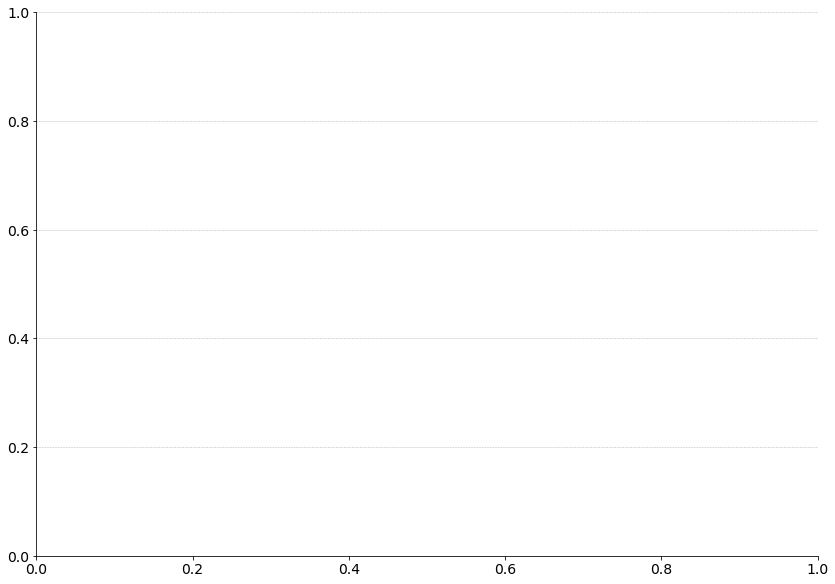

In [11]:
label = ["Cidade", "Código IBGE", "Estado", "População", "Último Dia", "Data", "Dia", "Casos Confirmados", 
           "Óbitos Confirmados", "Novos Casos", "Novas Mortes", "Incidência", "Mortalidade"]

for i in range(5) :

    df_UF = df_cidades.loc[df_cidades['region'].eq(reg[i]), :].sort_values('date', ascending = True).reset_index(drop = True)

    df_UF = df_UF[['city', 'city_ibge_code', 'state', 'population', 'is_last', 'date', 'day',
                             'confirmed', 'deaths', 'new_confirmed', 'new_deaths', 'incidence', 'death_rate']]

    estados_e = list(df_UF.sort_values('state', ascending = True)['state'].unique())

    for f in range(7, 13) :

        plt.rc('font', size = 14)
        plt.rcParams['figure.figsize'] = [14, 10]
        plt.tick_params(axis = "both", which = "both", bottom = "off", top = "off",    
                        labelbottom = "on", left = "off", right = "off", labelleft = "on")

        plt.grid(True, axis = 'y', linestyle = "dashed", lw = 0.5, color = "black", alpha = 0.3)
        plt.gca().spines["top"].set_visible(False)    
        plt.gca().spines["right"].set_visible(False)
        plt.gca().get_xaxis().tick_bottom()    
        plt.gca().get_yaxis().tick_left()        

        if f in [11, 12] :
            cidades_c = list(df_UF.sort_values(df_UF.columns[f - 4], ascending = False)['city'].unique())
        else :
            cidades_c = list(df_UF.sort_values(df_UF.columns[f], ascending = False)['city'].unique())

        x_max = max(df_UF.loc[:, 'day'])
        if len(cidades_c) >= 5 :
            y_min = max(df_UF.loc[df_UF['city'] == cidades_c[5], :].iloc[:, f])
        else :
            y_min = max(df_UF.loc[df_UF['city'] == cidades_c[len(cidades_c) - 1], :].iloc[:, f])

        y_max = max(df_UF.loc[df_UF['city'] == cidades_c[0], :].iloc[:, f]) 

        for c in range(len(cidades_c)) : 
            for e in range(len(estados_e)) :
                # Real data
                x = list(df_UF.loc[(df_UF['city'] == cidades_c[c]) & (df_UF['state'] == estados_e[e]), :].loc[:, 'day'])

                if f in [9, 10] :
                    y = list(df_UF.loc[(df_UF['city'] == cidades_c[c]) & (df_UF['state'] == estados_e[e]),
                                       :].iloc[:, f].rolling(window = 7).mean())

                    if c < 5 :
                        plt.plot(x, y, marker = ' ', color = (.3, .3, .3, .5), lw = 3)

                    if c == 5 :
                        plt.plot(0, 0, marker = ' ', label = 'Média 7 dias', color = (.3, .3, .3, .5), lw = 3)

                y = list(df_UF.loc[(df_UF['city'] == cidades_c[c]) & (df_UF['state'] == estados_e[e]), :].iloc[:, f])

                if len(x) > x_max :
                    x_max = len(x)
                if max(y) > y_max :
                    y_max = max(y)            

                if (c > 5) :
                    if f in [12] :
                        if max(df_UF.loc[(df_UF['city'] == cidades_c[c]) & (df_UF['state'] == estados_e[e]), :].iloc[:, 8]) > 5 :
                            plt.plot(x, y, marker = ' ', color = (.5, .5, .5, .3), lw = 1.5)
                    else:   
                        plt.plot(x, y, marker = ' ', color = (.5, .5, .5, .3), lw = 1.5)

                elif c == 5 :
                    plt.plot(x, y, marker = ' ', label = 'Outros municípios', color = (.5, .5, .5, .3), lw = 1.5)
                elif (c >= 1) & (c < 5) :
                    plt.plot(x, y, marker = ' ', label = cidades_c[c], color = color[c], lw = 2.5)
                    ys = y_min + (y_max - y_min) / c

                    #if f in range(7, 12) :
                        #plt.text(x_max * 1.01, ys * 0.6, cidades_c[c], color = color[c], fontsize = 14)

                elif (c == 0): 
                    plt.plot(x, y, marker = ' ', label = cidades_c[c], color = color[c], lw = 2.5)

                    #if f in range(7, 12) :
                        #plt.text(x_max * 1.01, y_max * 1.01, cidades_c[c], color = color[c], fontsize = 14)

                plt.xlim(1, x_max + 1)

                if f in [12] :
                    plt.ylim(0, y_max * .53)
                else :
                    plt.ylim(0, y_max * 1.03)

        plt.title(label[f] + " no " + reg[i] + " - " + estados_e[e])
        plt.legend()
        #plt.yscale('log')
        plt.xlabel("Dias após o primeiro confirmado")
        plt.ylabel(label[f])
        plt.savefig('Graphics/' + label[f] + ' ' + estados_e[e] +".png")
        plt.show()

In [12]:
cidades_c


['Salvador',
 'Fortaleza',
 'Recife',
 'Aracaju',
 'Maceió',
 'João Pessoa',
 'Natal',
 'São Luís',
 'Teresina',
 'Sobral',
 'Campina Grande',
 'Jaboatão dos Guararapes',
 'Feira de Santana',
 'Maracanaú',
 'Imperatriz',
 'Caucaia',
 'Olinda',
 'Juazeiro do Norte',
 'Arapiraca',
 'Parnaíba',
 'Parnamirim',
 'Mossoró',
 'Santa Inês',
 'Itabuna',
 'Lauro de Freitas',
 'Paulista',
 'Guarabira',
 'Açailândia',
 'Caruaru',
 'Bacabal',
 'Quixadá',
 'Camaçari',
 'Zé Doca',
 'Maranguape',
 'Caxias',
 'Cabedelo',
 'Chapadinha',
 'Barra do Corda',
 'Nossa Senhora do Socorro',
 'Camocim',
 'Acaraú',
 'Patos',
 'Teixeira de Freitas',
 'Ilhéus',
 'São Gonçalo do Amarante',
 'Codó',
 'Itapipoca',
 'Timon',
 'Santa Luzia',
 'Jequié',
 'Itabaiana',
 'Tianguá',
 'Mamanguape',
 'Crato',
 'Russas',
 'Itarema',
 'Santa Rita',
 'Eusébio',
 'Canindé',
 'Marechal Deodoro',
 'Buriticupu',
 'Camaragibe',
 'Balsas',
 'Juazeiro',
 'Iguatu',
 'Pinheiro',
 'Pacatuba',
 'Grajaú',
 'Pedreiras',
 'Coelho Neto',
 'Vit

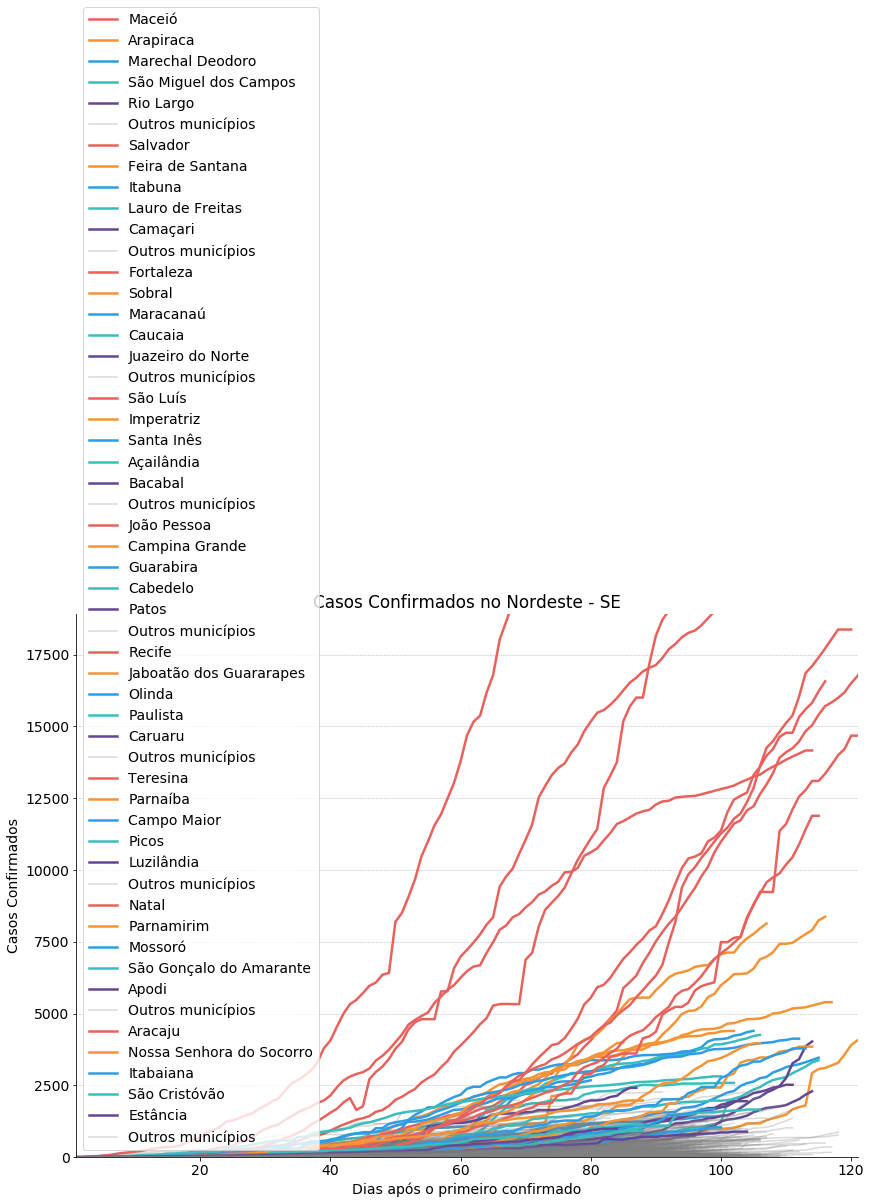

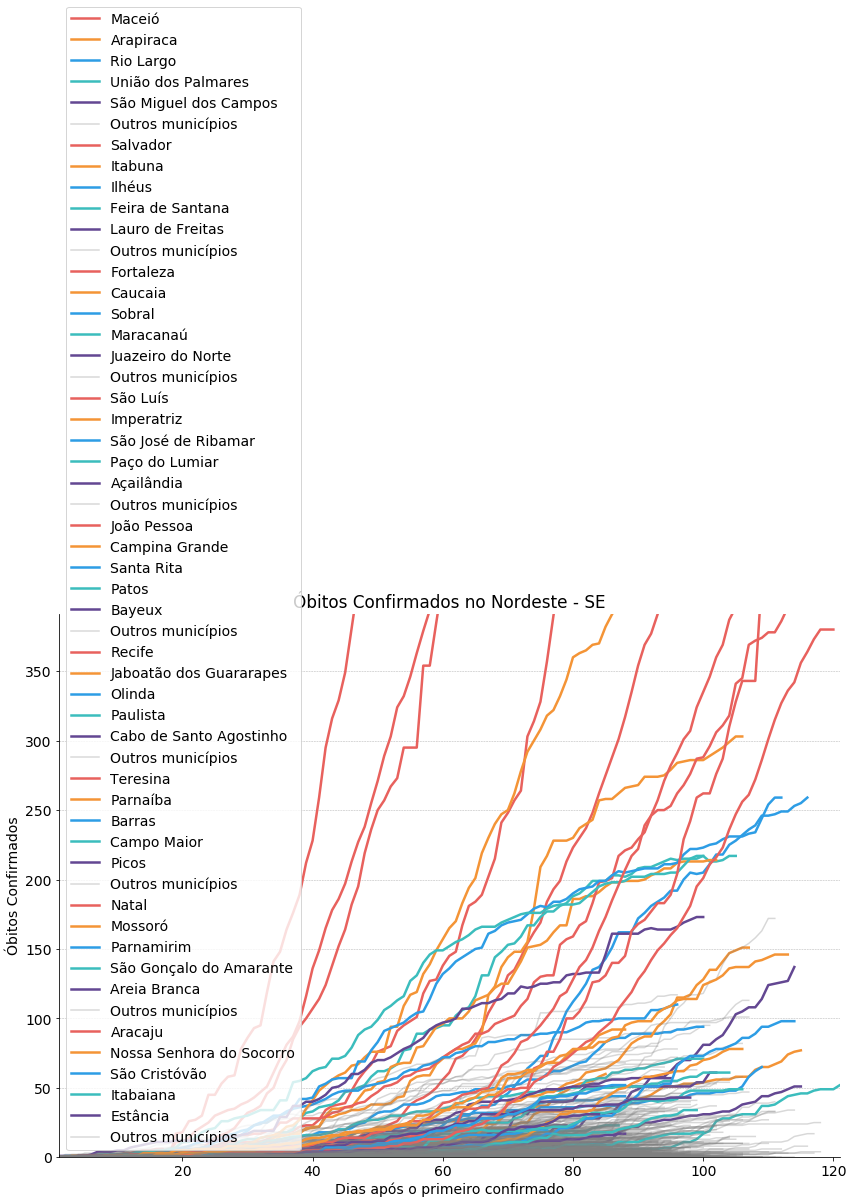

KeyboardInterrupt: 

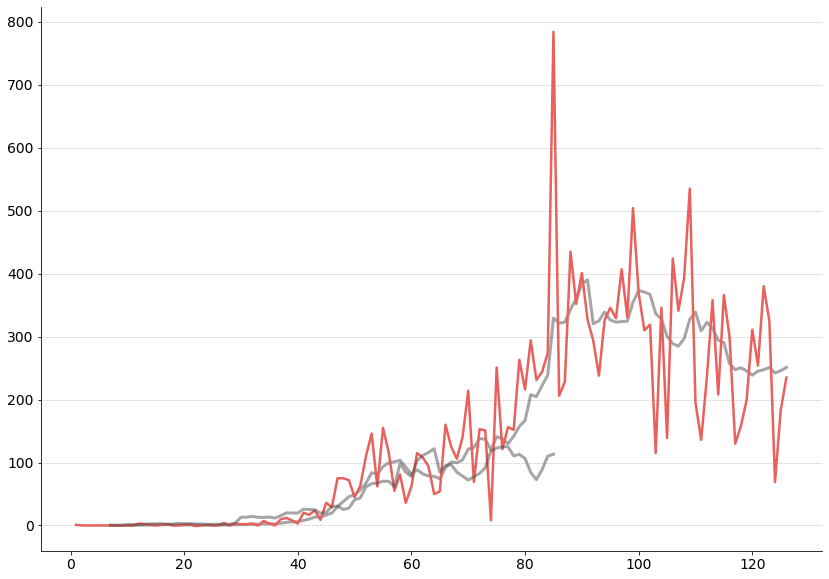

In [13]:
label = ["Cidade", "Código IBGE", "Estado", "População", "Último Dia", "Data", "Dia", "Casos Confirmados", 
           "Óbitos Confirmados", "Novos Casos", "Novas Mortes", "Incidência", "Mortalidade"]

for i in range(5) :

    df_UF = df_cidades.loc[df_cidades['region'].eq(reg[i]), :].sort_values('date', ascending = True).reset_index(drop = True)

    df_UF = df_UF[['city', 'city_ibge_code', 'state', 'population', 'is_last', 'date', 'day',
                             'confirmed', 'deaths', 'new_confirmed', 'new_deaths', 'incidence', 'death_rate']]

    estados_e = list(df_UF.sort_values('state', ascending = True)['state'].unique())

    for f in range(7, 13) :
        plt.rc('font', size = 14)
        plt.rcParams['figure.figsize'] = [14, 10]
        plt.tick_params(axis = "both", which = "both", bottom = "off", top = "off",    
                        labelbottom = "on", left = "off", right = "off", labelleft = "on")

        plt.grid(True, axis = 'y', linestyle = "dashed", lw = 0.5, color = "black", alpha = 0.3)
        plt.gca().spines["top"].set_visible(False)    
        plt.gca().spines["right"].set_visible(False)
        plt.gca().get_xaxis().tick_bottom()    
        plt.gca().get_yaxis().tick_left()        
        
        for e in range(len(estados_e)) :
            if f in [11, 12] :
                cidades_c = list(df_UF.loc[df_UF['state'] == estados_e[e],
                                           :].sort_values(df_UF.columns[f - 4], ascending = False)['city'].unique())
            else :
                cidades_c = list(df_UF.loc[df_UF['state'] == estados_e[e],
                                           :].sort_values(df_UF.columns[f], ascending = False)['city'].unique())

            x_max = max(df_UF.loc[df_UF['state'] == estados_e[e], :].loc[:, 'day'])
            
            if len(cidades_c) >= 5 :
                y_min = max(df_UF.loc[df_UF['city'] == cidades_c[5], :].iloc[:, f])
            else :
                y_min = max(df_UF.loc[df_UF['city'] == cidades_c[len(cidades_c) - 1], :].iloc[:, f])
                
            y_max = max(df_UF.loc[df_UF['city'] == cidades_c[0], :].iloc[:, f]) 

            for c in range(len(cidades_c)) : 
                # Real data
                x = list(df_UF.loc[(df_UF['city'] == cidades_c[c]) & (df_UF['state'] == estados_e[e]), :].loc[:, 'day'])
                
                if f in [9, 10] :
                    y = list(df_UF.loc[(df_UF['city'] == cidades_c[c]) & (df_UF['state'] == estados_e[e]),
                                       :].iloc[:, f].rolling(window = 7).mean())
                    
                    if c < 5 :
                        plt.plot(x, y, marker = ' ', color = (.3, .3, .3, .5), lw = 3)
                    
                    if c == 5 :
                        plt.plot(0, 0, marker = ' ', label = 'Média 7 dias', color = (.3, .3, .3, .5), lw = 3)
                    
                y = list(df_UF.loc[(df_UF['city'] == cidades_c[c]) & (df_UF['state'] == estados_e[e]), :].iloc[:, f])         

                if (c > 5) :
                    if f in [12] :
                        if max(df_UF.loc[(df_UF['city'] == cidades_c[c]) & (df_UF['state'] == estados_e[e]), :].iloc[:, 8]) > 5 :
                            plt.plot(x, y, marker = ' ', color = (.5, .5, .5, .3), lw = 1.5)
                    else:   
                        plt.plot(x, y, marker = ' ', color = (.5, .5, .5, .3), lw = 1.5)

                elif c == 5 :
                    plt.plot(x, y, marker = ' ', label = 'Outros municípios', color = (.5, .5, .5, .3), lw = 1.5)
                elif (c >= 1) & (c < 5) :
                    plt.plot(x, y, marker = ' ', label = cidades_c[c], color = color[c], lw = 2.5)
                    ys = y_min + (y_max - y_min) / c

                    #if f in range(7, 12) :
                        #plt.text(x_max * 1.01, ys * 0.6, cidades_c[c], color = color[c], fontsize = 14)

                elif (c == 0): 
                    plt.plot(x, y, marker = ' ', label = cidades_c[c], color = color[c], lw = 2.5)

                    #if f in range(7, 12) :
                        #plt.text(x_max * 1.01, y_max * 1.01, cidades_c[c], color = color[c], fontsize = 14)
            
            if len(x) > x_max :
                x_max = len(x)
            if max(y) > y_max :
                y_max = max(y)
                    
            plt.xlim(1, x_max + 1)

            if f in [12] :
                plt.ylim(0, y_max * .53)
            else :
                plt.ylim(0, y_max * 1.03)

        plt.title(label[f] + " no " + reg[i] + " - " + estados_e[e])
        plt.legend()
        #plt.yscale('log')
        plt.xlabel("Dias após o primeiro confirmado")
        plt.ylabel(label[f])
        #plt.savefig('Graphics/' + label[f] + ' ' + estados_e[e] +".png")
        plt.show()

In [ ]:
df_NEh = df_NE.loc[(df_NE["is_last"] == True), :].drop(['date', 'is_last'], axis = 1)
df_NEh = df_NEh.loc[(df_NEh["city"] != 'Importados/Indefinidos'), :]
df_NEh['city_ibge_code'] = df_NEh['city_ibge_code'].astype(int).astype(str)

m = folium.Map(
    name = 'COVID19 Nordeste',
    width = 800, height = 600,
    location = [-7, -36.75], # centro paraiba 
    zoom_start = 8,
    min_zoom = 6,
    max_zoom = 18,
    zoom_control = False,
    tiles = 'OpenStreetMap'#'cartodbpositron'
)

m.choropleth(
    geo_data = geo,
    name = 'Casos Confirmados',
    data = df_NEh,
    columns = ['city_ibge_code', 'confirmed'],
    key_on = 'feature.properties.id',
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    nan_fill_color = 'gray',
    nan_fill_opacity = 0.2,
    line_color = '#634792',
    line_opacity = 0.3,
    legend_name = 'Casos Confirmados',
    legend_fontsize = '14',
    bins = [0, 1, 10, 100, 1000, 10000, 100000]
)

m.choropleth(
    geo_data = geo,
    name = 'Mortes Confirmadas',
    data = df_NEh,
    columns = ['city_ibge_code', 'deaths'],
    key_on = 'feature.properties.id',
    fill_color = 'Reds',
    fill_opacity = 0.7,
    nan_fill_color = 'gray',
    nan_fill_opacity = 0.2,
    line_color = '#634792',
    line_opacity = 0.3,
    legend_name = 'Óbitos Confirmados',
    legend_fontsize = '14',
    bins = [0, 1, 10, 100, 1000, 10000],
    show = False
)

folium.LayerControl(name = 'COVID19 Nordeste', position = 'topright').add_to(m)

m.save('mapa.html')
m